# 1. Importing Libraries

In [1]:
# Important libraries
import numpy as np
import nengo
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 2. Loading in important data properties

### 2.1 Basic File Properties

In [2]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S1"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = r"..\\..\\Data Extraction\\"+monkey+"_raw.csv"

# 3. Functional Decoders

### 3.1 Implementing the Functional Decoder Function

In [3]:
data_df = pd.read_csv(datafile_path)
train_df, test_df = train_test_split(data_df, test_size=0.4, shuffle=False)

In [4]:
headers = data_df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)

# Getting the train activity and kinematic matrix
activity_matrix = test_df.loc[:, 'Neuron1':f'Neuron{n_neurons}']
kinem_matrix = test_df.loc[:, 'x_velocity':'y_acceleration']

# Transpose data to ensure that dimensions are correct for decoder values
tranposed_activity_matrix = activity_matrix.transpose()
tranposed_kinem_matrix = kinem_matrix.transpose()

A = tranposed_activity_matrix.to_numpy()  # n_neurons x n_timepoints
Y = tranposed_kinem_matrix.to_numpy()    # n_kinematics x n_timepoints

Y = Y[2:4] # Isolating for accelerations


# 4. Building the Minimal Effort Nengo Model

### 4.1 Setting up and Adjusting Model Parameters

In [5]:
spikes = A
scaler = np.max(Y)
kin_data = Y / scaler
dt = 0.001
dti = 1/dt
spikes = spikes*dti

# Parameters to change
n_ensemble_neurons = 5000
ensemble_radius = 2
ensemble_synapse = 0.025
probe_synapse = 0.01
training_time = 150

### 4.2 Implementing the Nengo Model

In [6]:
# Nengo Network Using Recorded Spikes as Input
np.random.seed(0)
with nengo.Network() as model:

    # Input signal
    input_node = nengo.Node(lambda t: spikes[:,int(t / dt) - 1])

    # Connect input spikes to another node with a synapse of 0.05
    input_node_lowpassed = nengo.Node(size_in=n_neurons)
    input_conn = Connection(input_node, input_node_lowpassed, synapse = 0.05)

    # Connect low-passed input to the first ensemble (neuron representation)
    representation_ensemble = nengo.Ensemble(n_neurons=n_ensemble_neurons, dimensions=n_neurons, radius = ensemble_radius)
    nengo.Connection(input_node_lowpassed, representation_ensemble, synapse=ensemble_synapse)

    # Connect first ensemble to output ensemble
    output_ensemble = nengo.Ensemble(n_neurons=n_ensemble_neurons, dimensions=2, radius = ensemble_radius)
    learn_conn = nengo.Connection(representation_ensemble, output_ensemble,  function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=2e-4))

    # Connect output to error
    error_ensemble = nengo.Ensemble(n_neurons=n_ensemble_neurons, dimensions=2, radius = ensemble_radius)
    nengo.Connection(output_ensemble, error_ensemble)

    # Connect error to the learning connection
    nengo.Connection(error_ensemble, learn_conn.learning_rule)

    # Get ground truth value
    truth_node = nengo.Node(lambda t: kin_data[:,int(t/dt) -1])
    nengo.Connection(truth_node, error_ensemble, transform=-1)

    p_post = nengo.Probe(output_ensemble, synapse=probe_synapse)

    stop_learning = nengo.Node(output=lambda t: t >= 0.8*150)
    nengo.Connection(
        stop_learning, error_ensemble.neurons, transform=-20 * np.ones((error_ensemble.n_neurons, 1))
    )

### 4.3 Running the Model and Plotting the Output

Build finished in 0:00:17.                                                      
Simulation finished in 0:02:01.                                                 


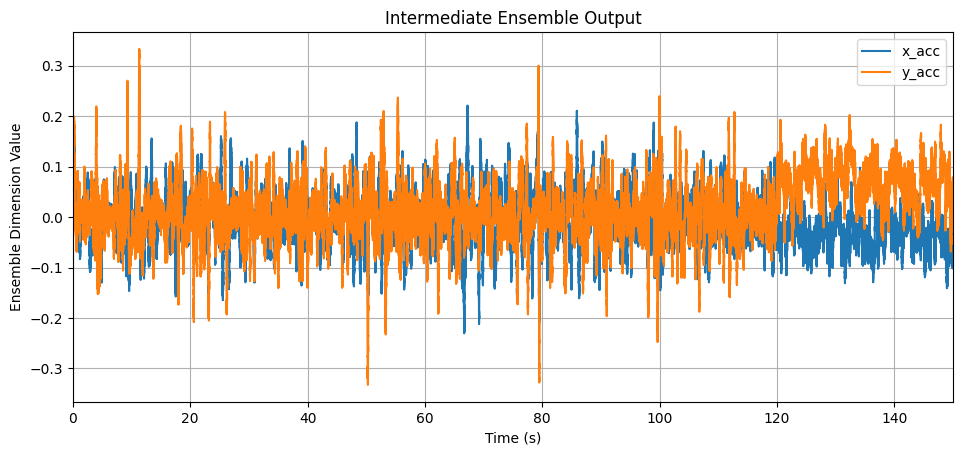

In [7]:
with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(training_time)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

# 5. Plotting and Comparing the Outputs

### 5.2 Acceleration Comparisons

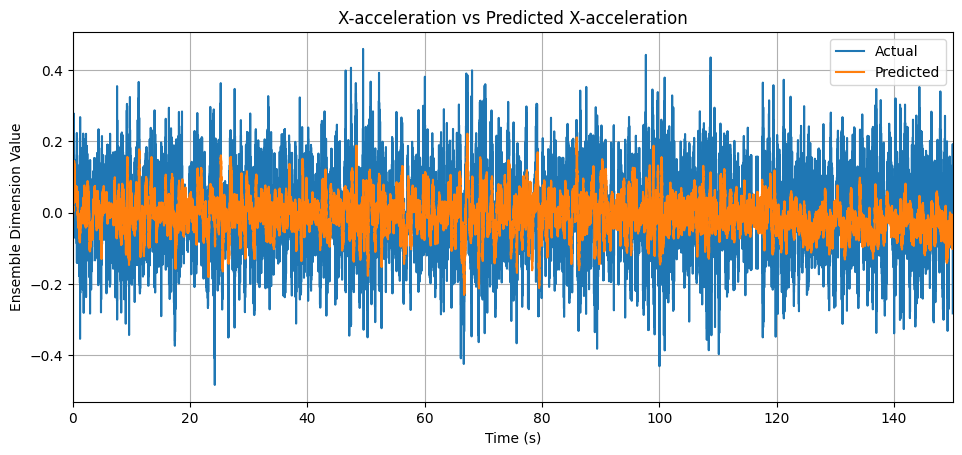

In [8]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), kin_data[0, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_post][:, 0])
pl.set_title("X-acceleration vs Predicted X-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

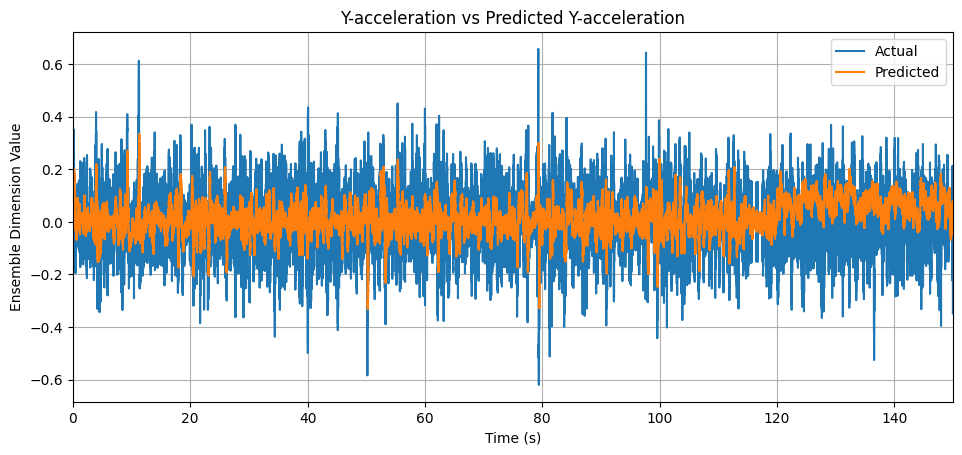

In [9]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), kin_data[1, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_post][:, 1])
pl.set_title("Y-acceleration vs Predicted Y-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

# 6. Evautating Effectiveness of the Model

### 6.1 Implementing the Error Functions

In [10]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

### 6.2 Calculating Errors

In [11]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(kin_data[0, 0:len(sim.trange())], sim.data[p_post][:, 0])
print("")

# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(kin_data[1, 0:len(sim.trange())], sim.data[p_post][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.0672813373829504
Root Mean_Squared Error: 0.08822123460141294

Y-Acceleration Error
Mean Absolute Error: 0.07903235006454662
Root Mean_Squared Error: 0.10461023741092391



# Plotting Velocities

In [12]:
true_accels = kin_data[:, 0:len(sim.trange())]
pred_accels = [ sim.data[p_post][:, 0], sim.data[p_post][:, 1] ]

true_accels = np.array(true_accels) * scaler
pred_accels = np.array(pred_accels) * scaler

In [13]:
sdt = 20.0/len(sim.trange())

true_vels = []
for i in range(2):
    vel = []
    velsum = 0
    for j in range(len(true_accels[0])):
        velsum += true_accels[i][j] * sdt
        vel.append(velsum)

    true_vels.append(vel)

pred_vels = []
for i in range(2):
    vel = []
    velsum = 0
    for j in range(len(true_accels[0])):
        velsum += pred_accels[i][j] * sdt
        vel.append(velsum)

    pred_vels.append(vel)

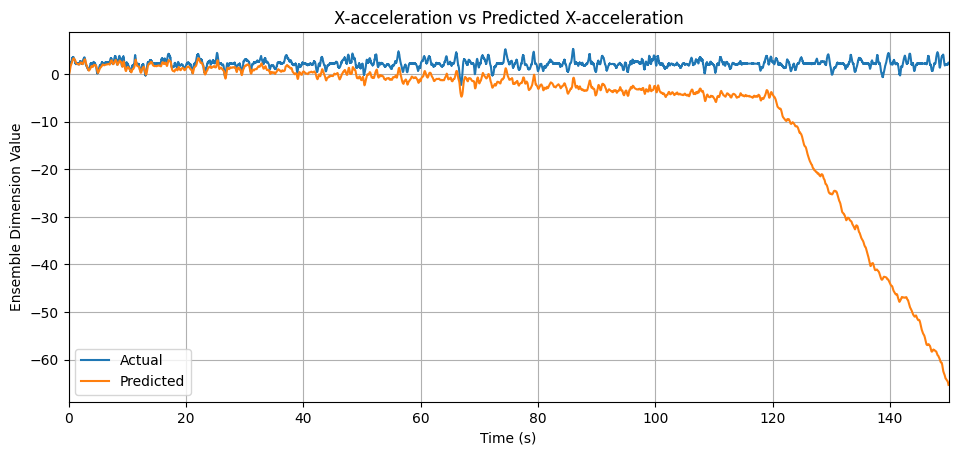

In [14]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), true_vels[0])
pl.plot(sim.trange(), pred_vels[0])
pl.set_title("X-acceleration vs Predicted X-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

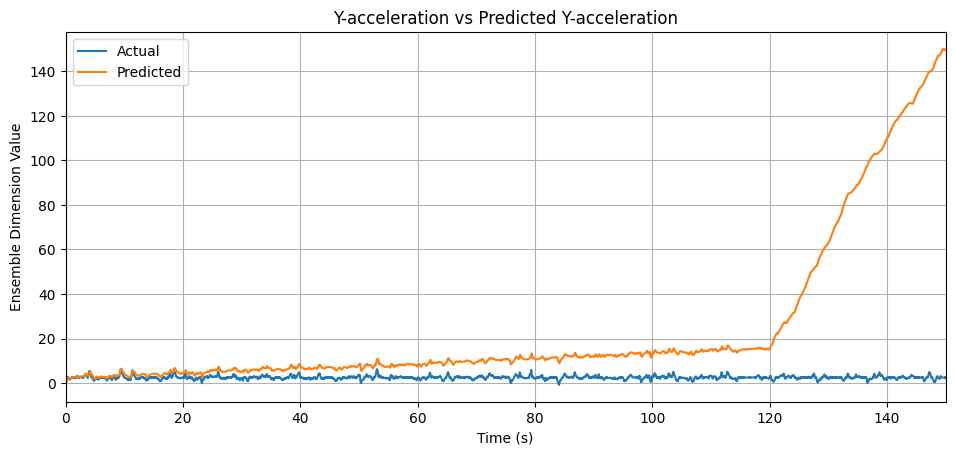

In [15]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), true_vels[1])
pl.plot(sim.trange(), pred_vels[1])
pl.set_title("Y-acceleration vs Predicted Y-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()